# Temporary Notebook to show the work in progress attempt at extracting the gene "weights" from the classifier when using PCA. Starts at cell 22. 

In [1]:
import datetime
import json
import os
import time

from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from dask_searchcv import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from vega import Vega
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils import fill_spec_with_data, get_model_coefficients

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'TP53' classifier 
mutation_id = '7157' # TP53

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [4]:
%%time
path = os.path.join('download', 'expression-matrix.tsv.bz2')
expression_df = pd.read_table(path, index_col=0)

Wall time: 3min 55s


In [5]:
%%time
path = os.path.join('download', 'mutation-matrix.tsv.bz2')
mutation_df = pd.read_table(path, index_col=0)

Wall time: 1min 50s


In [6]:
path = os.path.join('download', 'covariates.tsv')
covariate_df = pd.read_table(path, index_col=0)

# Select acronym_x and n_mutations_log1p covariates only
selected_cols = [col for col in covariate_df.columns if col.startswith('acronym_')]
selected_cols.append('n_mutations_log1p')
covariate_df = covariate_df[selected_cols]

In [7]:
# The series holds TP53 Mutation Status for each sample
y = mutation_df[mutation_id]
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: 7157, dtype: int64

In [8]:
print('Gene expression matrix shape: {}'.format(expression_df.shape))
print('Covariates matrix shape: {}'.format(covariate_df.shape))

Gene expression matrix shape: (7306, 20468)
Covariates matrix shape: (7306, 33)


## Set aside 10% of the data for testing

In [9]:
# Typically, this type of split can only be done 
# for genes where the number of mutations is large enough
X = pd.concat([covariate_df, expression_df], axis='columns')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Here are the percentage of tumors with TP53
y.value_counts(True)

0    0.645907
1    0.354093
Name: 7157, dtype: float64

## Feature selection

In [10]:
def select_feature_set_columns(X, feature_set):
    """
    Select the feature set for the different models within the pipeline
    """
    n_covariates = len(covariate_df.columns)
    if feature_set == 'covariates':
        return X[:, :n_covariates]
    if feature_set == 'expressions':
        return X[:, n_covariates:]
    raise ValueError('feature_set not supported: {}'.format(feature_set))

# Creates the expression features by standarizing them and running PCA
# Because the expressions matrix is so large, we preprocess with PCA
# The amount of variance in the data captured by ~100 components is high
expression_features = Pipeline([
    ('select_features', FunctionTransformer(select_feature_set_columns,
        kw_args={'feature_set': 'expressions'})),
    ('standardize', StandardScaler()),
    ('pca', PCA())
])

# Creates the covariate features by selecting and standardizing them
covariate_features = Pipeline([
    ('select_features', FunctionTransformer(select_feature_set_columns,
        kw_args={'feature_set': 'covariates'})),
    ('standardize', StandardScaler())
])

## Elastic net classifier and model paraemeters

In [11]:
# Parameter Sweep for Hyperparameters
n_components_list = [50, 100]
regularization_alpha_list = [10 ** x for x in range(-3, 1)]
regularization_l1_ratio = 0.15

param_grids = {
    'full': {
        'features__expressions__pca__n_components' : n_components_list,
        'classify__alpha': regularization_alpha_list
    },
    'expressions': {
        'features__expressions__pca__n_components' : n_components_list,
        'classify__alpha': regularization_alpha_list
    },
    'covariates': {
        'classify__alpha': regularization_alpha_list
    }
}

# Classifier: Elastic Net
classifier = SGDClassifier(penalty='elasticnet',
                           l1_ratio=regularization_l1_ratio,
                           loss='log', 
                           class_weight='balanced',
                           random_state=0)

## Define pipeline and cross validation

In [12]:
# Full model pipelines
pipeline_definitions = {
    'full': Pipeline([
        ('features', FeatureUnion([
            ('expressions', expression_features),
            ('covariates', covariate_features)
        ])),
        ('classify', classifier)
    ]),
    'expressions': Pipeline([
        ('features', FeatureUnion([('expressions', expression_features)])),
        ('classify', classifier)
    ]),
    'covariates': Pipeline([
        ('features', FeatureUnion([('covariates', covariate_features)])),
        ('classify', classifier)
    ])
}

# Construct cross-validated grid searches
cv_pipelines = dict()
for model, pipeline in pipeline_definitions.items():
    cv = StratifiedKFold(n_splits=3, random_state=0)
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[model],
        cv=cv,
        n_jobs=1, 
        scoring='roc_auc',
    )
    cv_pipelines[model] = grid_search

In [13]:
# Fit the models
for model, pipeline in cv_pipelines.items():
    print('Fitting CV for model: {0}'.format(model))
    start_time = time.perf_counter()
    pipeline.fit(X=X_train, y=y_train)
    end_time = time.perf_counter()
    elapsed = datetime.timedelta(seconds=end_time - start_time)
    print('\truntime: {}'.format(elapsed))

Fitting CV for model: full
	runtime: 0:03:27.984407
Fitting CV for model: expressions
	runtime: 0:02:55.600553
Fitting CV for model: covariates
	runtime: 0:00:19.101731


In [14]:
# Best Parameters
for model, pipeline in cv_pipelines.items():
    print('#', model)
    print(pipeline.best_params_)
    print('cv_auroc = {:.3%}'.format(pipeline.best_score_))

# full
{'features__expressions__pca__n_components': 50, 'classify__alpha': 1}
cv_auroc = 87.873%
# expressions
{'features__expressions__pca__n_components': 100, 'classify__alpha': 1}
cv_auroc = 87.861%
# covariates
{'classify__alpha': 0.01}
cv_auroc = 84.206%


## Visualize hyperparameters performance

In [15]:
cv_results_df = pd.DataFrame()
for model, pipeline in cv_pipelines.items():
    df = pd.concat([
        pd.DataFrame(pipeline.cv_results_),
        pd.DataFrame.from_records(pipeline.cv_results_['params'])
    ], axis='columns')
    df['feature_set'] = model
    cv_results_df = cv_results_df.append(df)

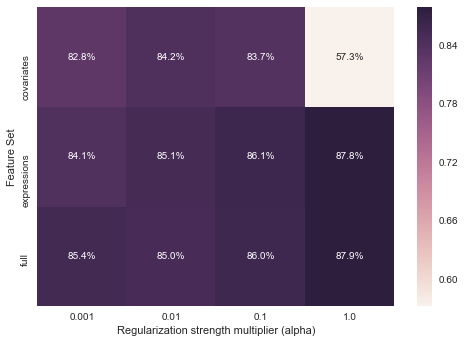

In [16]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_results_df,
                              values='mean_test_score', 
                              index='feature_set',
                              columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Feature Set');

## Use optimal hyperparameters to output ROC curve

In [17]:
y_pred_dict = {
    model: {
        'train': pipeline.decision_function(X_train),
        'test':  pipeline.decision_function(X_test)
    } for model, pipeline in cv_pipelines.items()
}

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_dict = {    
    model: {
        'train': get_threshold_metrics(y_train, y_pred_dict[model]['train']),
        'test':  get_threshold_metrics(y_test, y_pred_dict[model]['test'])
    } for model in y_pred_dict.keys()
}

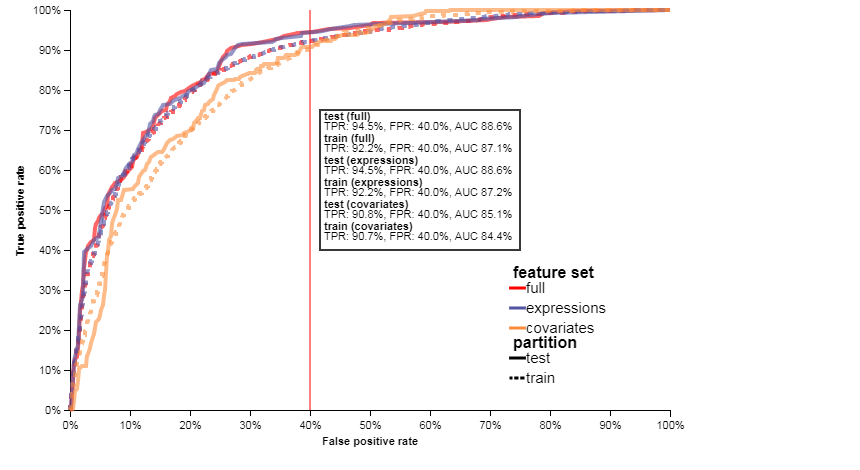

In [18]:
# Assemble the data for ROC curves
model_order = ['full', 'expressions', 'covariates']

auc_output = pd.DataFrame()
roc_output = pd.DataFrame()

for model in model_order:
    metrics_partition = metrics_dict[model]
    for partition, metrics in metrics_partition.items():
        auc_output = auc_output.append(pd.DataFrame({
            'partition': [partition],
            'feature_set': [model],
            'auc': metrics['auroc']
        }))
        roc_df = metrics['roc_df']
        roc_output = roc_output.append(pd.DataFrame({
            'false_positive_rate': roc_df.fpr,
            'true_positive_rate': roc_df.tpr,
            'partition': partition,
            'feature_set': model
        }))
auc_output['legend_index'] = range(len(auc_output.index))

with open('vega_specs/roc_vega_spec.json', 'r') as fp:
    vega_spec = json.load(fp)

final_spec = fill_spec_with_data(vega_spec, 
    {'roc': roc_output, 'legend_auc': auc_output})

Vega(final_spec)

## What are the classifier coefficients?

In [19]:
final_pipelines = {
    model: pipeline.best_estimator_
    for model, pipeline in cv_pipelines.items()
}
final_classifiers = {
    model: pipeline.named_steps['classify']
    for model, pipeline in final_pipelines.items()
}

coef_df = pd.concat([
    get_model_coefficients(classifier, model, covariate_df.columns)
    for model, classifier in final_classifiers.items()
])

In [20]:
# Signs of the coefficients by model
pd.crosstab(coef_df.feature_set, np.sign(coef_df.weight).rename('coefficient_sign'))

coefficient_sign,-1.0,0.0,1.0
feature_set,,,
covariates,15,5,13
expressions,15,74,11
full,13,59,11


In [21]:
# Top standardized coefficients for the full data-set
(coef_df
    .query("feature_set == 'full'")
    .head(10)
)

,feature,weight,abs,feature_set
8,PCA_8,-0.036677,0.036677,full
29,PCA_29,-0.035741,0.035741,full
2,PCA_2,-0.035417,0.035417,full
11,PCA_11,-0.031165,0.031165,full
24,PCA_24,0.030545,0.030545,full
22,PCA_22,-0.029107,0.029107,full
37,PCA_37,0.029088,0.029088,full
1,PCA_1,-0.027869,0.027869,full
34,PCA_34,-0.022898,0.022898,full
44,PCA_44,0.020728,0.020728,full


# Identify top genes

In [22]:
def get_genes_coefficients(pca_object, classifier_object,
                           expression_df=expression_df):
    """Identify gene coefficients from classifier after pca.

    Args:
        pca_object: The pca object from running pca on the expression_df.
        classifier_object: The logistic regression classifier object.
        expression_df: The original (pre-pca) expression data frame.

    Returns:
        gene_coefficients: A dataframe with entreze gene-ID, coefficient and
                            abbsolute value of coefficient. The dataframe is
                            sorted by absolute value of coefficient.
    """

    # Get the classifier coefficients.
    coefficients = classifier_object.coef_
    coefficients = pd.DataFrame(coefficients).T
    # Get the pca weights.
    weights = pca_object.components_
    headers = list(expression_df)
    weights = pd.DataFrame(weights, columns=headers)
    # Combine the coefficients and weights.
    combined_df = pd.DataFrame(weights.values*coefficients.values,
                               columns=weights.columns, index=weights.index)
    gene_coefficients = combined_df.sum(axis=0)
    gene_coefficients = gene_coefficients.to_frame()
    gene_coefficients.columns = ['weight']
    # Add absolute value and sort by highest absolute value.
    gene_coefficients['abs'] = gene_coefficients['weight'].abs()
    gene_coefficients.sort_values(by='abs', axis=0, ascending=False,
                                  inplace=True)
    return(gene_coefficients)

In [23]:
pca_from_expression = final_pipelines['expressions'].named_steps['features'].get_params()['expressions__pca']
classifier_from_expression = final_pipelines['expressions'].named_steps['classify']

In [24]:
gene_coefficients_from_expression = get_genes_coefficients(pca_object=pca_from_expression, classifier_object=classifier_from_expression)
gene_coefficients_from_expression.head(10)

,weight,abs
1643,-0.003576,0.003576
8767,0.003468,0.003468
25879,0.003335,0.003335
734,0.003207,0.003207
3654,0.003200,0.003200
157378,0.003190,0.003190
79581,0.003144,0.003144
6788,0.003113,0.003113
8704,0.003098,0.003098
114907,0.003050,0.003050


## Test the top genes

In [25]:
# Select the top genes from the topGenes dataframe
topGeneList = gene_coefficients_from_expression.index.tolist()
top10Genes = topGeneList[:10]
top30Genes = topGeneList[:30]
# Set X10 and X30 as the expresion data of only the top 10 and 30 genes
X = expression_df
X10 = X[top10Genes]
X30 = X[top30Genes]
# Set X10MAD as the expression data of only the top 10 genes from the MAD feature selection notebook:
# https://github.com/dhimmel/machine-learning/blob/pickle/2.TCGA-MLexample.ipynb
X10MAD = X[['60401', '9518', '1029', '55065', '56164', '80704', '11065', '84417', '283417', '8744']]

In [26]:
X10_train, X10_test, y_train, y_test = train_test_split(X10, y, test_size=0.1, random_state=0)
X30_train, X30_test, y10_train, y10_test = train_test_split(X30, y, test_size=0.1, random_state=0)
X10MAD_train, X10MAD_test, y10_train, y10_test = train_test_split(X10MAD, y, test_size=0.1, random_state=0)

In [27]:
# Parameter Sweep for Hyperparameters
param_grid = {
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': [10 ** x for x in range(-3, 1)],
    'classify__l1_ratio': [0],
}

pipeline = Pipeline(steps=[
    ('standardize', StandardScaler()),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

cv_pipeline10 = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=1, scoring='roc_auc')
cv_pipeline30 = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=1, scoring='roc_auc')
cv_pipeline10MAD = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=1, scoring='roc_auc')

In [28]:
%%time
cv_pipeline10.fit(X=X10_train, y=y_train)
cv_pipeline30.fit(X=X30_train, y=y_train)
cv_pipeline10MAD.fit(X=X10MAD_train, y=y_train)

Wall time: 1.14 s


In [29]:
y10_pred_train = cv_pipeline10.decision_function(X10_train)
y10_pred_test = cv_pipeline10.decision_function(X10_test)

y30_pred_train = cv_pipeline30.decision_function(X30_train)
y30_pred_test = cv_pipeline30.decision_function(X30_test)

y10MAD_pred_train = cv_pipeline10MAD.decision_function(X10MAD_train)
y10MAD_pred_test = cv_pipeline10MAD.decision_function(X10MAD_test)

def get_threshold_metrics(y_true, y_pred, tissue='all'):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df, 'tissue': tissue}

metrics_train10 = get_threshold_metrics(y_train, y10_pred_train)
metrics_test10 = get_threshold_metrics(y_test, y10_pred_test)

metrics_train30 = get_threshold_metrics(y_train, y30_pred_train)
metrics_test30 = get_threshold_metrics(y_test, y30_pred_test)

metrics_train10MAD = get_threshold_metrics(y_train, y10MAD_pred_train)
metrics_test10MAD = get_threshold_metrics(y_test, y10MAD_pred_test)

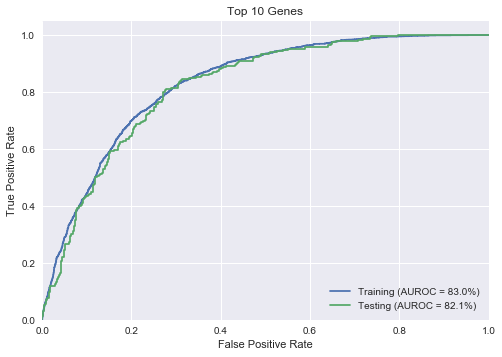

In [30]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train10), ('Testing', metrics_test10):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Top 10 Genes')
plt.legend(loc='lower right')

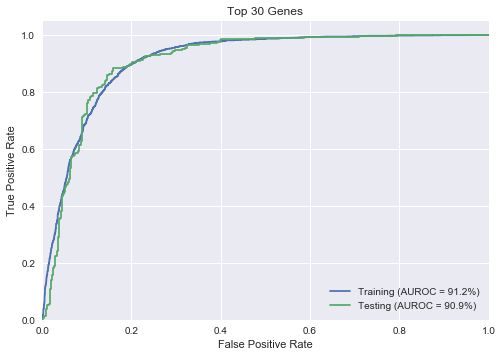

In [31]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train30), ('Testing', metrics_test30):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Top 30 Genes')
plt.legend(loc='lower right')

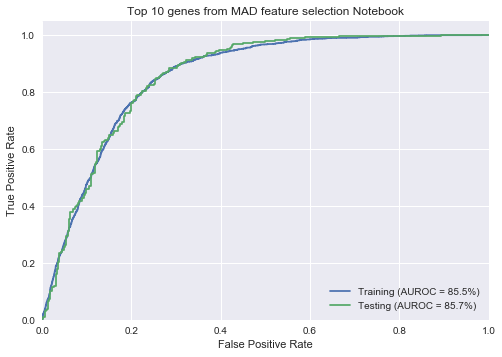

In [32]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train10MAD), ('Testing', metrics_test10MAD):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Top 10 genes from MAD feature selection Notebook')
plt.legend(loc='lower right')